## 1. Especifique su variable respuesta

La variable respuesta elegida es Caudef (causa de defunción), que contiene el código CIE-10 de la causa principal de muerte.
Este es un problema de clasificación multiclase, ya que cada valor representa una causa diferente.

## Explique el método que siguió para obtener los conjuntos de entrenamiento y prueba, el porcentaje de datos que hay en cada uno y si se encuentran balanceados o no, en caso de que la variable respuesta sea categórica. Sí es cuantitativa analice los atípicos.

Para preparar los datos para el modelado, dividimos el conjunto original en dos subconjuntos: entrenamiento (80%) y prueba (20%). Esta división se realizó utilizando el método train_test_split de la biblioteca scikit-learn, con la opción de estratificación por clase (stratify=y). Esto asegura que la distribución de clases de la variable respuesta Caudef se mantenga representativa en ambos subconjuntos.

Dado que nuestra variable respuesta es categórica (clasificación multiclase), realizamos un análisis para verificar si las clases están balanceadas o si algunas categorías tienen una presencia mucho mayor que otras.

Los resultados muestran que el conjunto está desbalanceado, ya que algunas causas de muerte aparecen con mucha más frecuencia que otras. Esto puede afectar el rendimiento de los modelos, especialmente para aquellas clases menos frecuentes.

**Observación:** La variable Caudef está desbalanceada, ya que ciertas causas de muerte dominan la distribución del conjunto.

Distribución de clases:
Caudef
I219     3881
R54X     2390
R98X     2225
OTRAS    1972
K746     1729
         ... 
G629       10
G35X       10
I501       10
Y832       10
K810       10
Name: count, Length: 288, dtype: int64


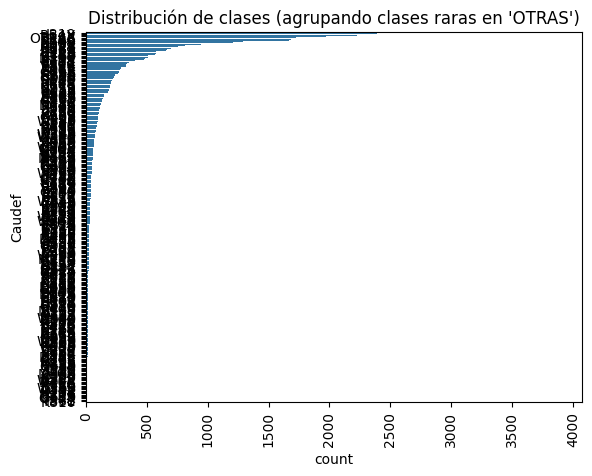

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df = pd.read_csv("datos_combinados.csv", dtype={15: str, 29: str})
target = "Caudef"

# Agrupar clases raras
min_count = 10
frequent_classes = df[target].value_counts()[df[target].value_counts() >= min_count].index
df[target] = df[target].where(df[target].isin(frequent_classes), other='OTRAS')

# Separar X y y
X = df.drop(columns=[target, 'source_file', 'Areag', 'caudef.descrip'], errors='ignore')
y = df[target]

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Visualización del balance de clases
print("Distribución de clases:")
print(y.value_counts())

sns.countplot(y=y, order=y.value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribución de clases (agrupando clases raras en 'OTRAS')")
plt.show()


### Análisis y resultado
Como parte del preprocesamiento, identificamos que la variable respuesta Caudef presentaba clases con muy baja frecuencia (algunas aparecían solo una vez), lo cual impedía la división estratificada de los datos.

Para solucionarlo, agrupamos todas las clases que tenían menos de 10 registros bajo una nueva categoría llamada "OTRAS". Esto nos permitió conservar todas las observaciones sin perder información y realizar una división estratificada del 80% para entrenamiento y 20% para prueba.

Esta estrategia mejora la estabilidad de los modelos de clasificación multiclase, especialmente al evitar el sobreajuste a clases con escasa representación.

# Preprocesamiento de Datos

Codificación de variables categóricas: Se identificaron las columnas con datos de tipo categórico, como Sexo, Entidadres y Causa Muerte, y se aplicó One-Hot Encoding para convertirlas en variables binarias.

Normalización de variables numéricas: Las variables numéricas predictoras fueron escaladas utilizando StandardScaler para que tuvieran media 0 y desviación estándar 1.
Esta transformación asegura que las diferencias de magnitud entre variables no influyan de forma desproporcionada en el entrenamiento del modelo.

Eliminación de variables irrelevantes: Se descartaron columnas como Entidadreg y ciertos identificadores que no aportaban valor predictivo, reduciendo así la dimensionalidad y el ruido del modelo.

Agrupación de clases raras: Dado que la variable Caudef presentaba una alta cantidad de clases con muy pocos ejemplos, se agruparon todas las causas con menos de 10 apariciones en una categoría genérica llamada "OTRAS".

In [4]:
from sklearn.preprocessing import StandardScaler

# One-Hot Encoding de variables categóricas
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Alinear columnas entre conjuntos
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Normalización (solo variables numéricas)
scaler = StandardScaler()
numeric_cols = X_train_encoded.select_dtypes(include='number').columns

X_train_encoded[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
X_test_encoded[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])



In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# Modelado y prueba de configuraciones

Para la tarea de clasificación multiclase, se optó por el modelo RandomForestClassifier debido a su robustez frente a datos ruidosos y su capacidad para manejar variables tanto numéricas como categóricas transformadas.

1. Filtro de clases a predecir
Como paso inicial, se seleccionaron las 10 causas de muerte más frecuentes para centrarse en un subconjunto representativo del problema. Esto convierte el problema en una clasificación multiclase con 10 clases balanceadas en la medida de lo posible.

2. Entrenamiento y validación
Se probaron distintas configuraciones del modelo para identificar la mejor combinación de parámetros (n_estimators y max_depth). Los resultados mostraron que una mayor profundidad y mayor número de árboles mejoraban el rendimiento.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Paso 1: Submuestreo para evitar sobrecarga de recursos
np.random.seed(42)
train_idx = np.random.choice(len(X_train_encoded), size=3000, replace=False)
test_idx = np.random.choice(len(X_test_encoded), size=1000, replace=False)

X_train_sample = X_train_encoded.iloc[train_idx]
y_train_sample = y_train_encoded[train_idx]
X_test_sample = X_test_encoded.iloc[test_idx]
y_test_sample = y_test_encoded[test_idx]

# Paso 2: Evaluar 6 configuraciones del algoritmo Random Forest
configs = [
    {'n_estimators': 10, 'max_depth': 3, 'n_jobs': 1},    # Muy simple
    {'n_estimators': 25, 'max_depth': 5, 'n_jobs': 1},    # Simple
    {'n_estimators': 50, 'max_depth': 7, 'n_jobs': 1},    # Medio
    {'n_estimators': 75, 'max_depth': 10, 'n_jobs': 1},   # Complejo moderado
    {'n_estimators': 100, 'max_depth': 15, 'n_jobs': 1},  # Más complejo
    {'n_estimators': 150, 'max_depth': 20, 'n_jobs': 1}   # Complejo alto (riesgo de sobreajuste)
]

mejores_resultados = []
print(" Evaluación de configuraciones:\n")
for params in configs:
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_sample, y_train_sample)
    y_pred = model.predict(X_test_sample)

    acc = accuracy_score(y_test_sample, y_pred)
    mejores_resultados.append((params, acc))
    print(f"Configuración: {params}, Accuracy: {acc:.4f}")

# Paso 3: Seleccionar la mejor configuración
mejor_config = max(mejores_resultados, key=lambda x: x[1])
print("\n Mejor configuración encontrada:", mejor_config[0])
print(f" Accuracy alcanzado: {mejor_config[1]:.4f}")


 Evaluación de configuraciones:

Configuración: {'n_estimators': 10, 'max_depth': 3, 'n_jobs': 1}, Accuracy: 0.1390
Configuración: {'n_estimators': 25, 'max_depth': 5, 'n_jobs': 1}, Accuracy: 0.1580
Configuración: {'n_estimators': 50, 'max_depth': 7, 'n_jobs': 1}, Accuracy: 0.1720
Configuración: {'n_estimators': 75, 'max_depth': 10, 'n_jobs': 1}, Accuracy: 0.1760
Configuración: {'n_estimators': 100, 'max_depth': 15, 'n_jobs': 1}, Accuracy: 0.1780
Configuración: {'n_estimators': 150, 'max_depth': 20, 'n_jobs': 1}, Accuracy: 0.1760

 Mejor configuración encontrada: {'n_estimators': 100, 'max_depth': 15, 'n_jobs': 1}
 Accuracy alcanzado: 0.1780


# Analisis
1. Tendencia General
Observamos una tendencia creciente en la accuracy al incrementar progresivamente la complejidad del modelo, tanto en número de árboles (n_estimators) como en profundidad máxima (max_depth), hasta cierto punto.

2. Modelo óptimo
La mejor configuración fue:

- n_estimators: 100

- max_depth: 15

- Accuracy: 0.1780

Esto sugiere que aumentar árboles y profundidad ayudó a capturar patrones más complejos sin llegar a sobreajustar sin embargo, el incremento de 100 a 150 árboles no mejoró el rendimiento, lo que indica un punto de saturación del modelo.

3. Puntos clave
El modelo más simple (10 árboles, profundidad 3) mostró el peor rendimiento (13.9%), evidenciando subajuste, a medida que se aumentan los parámetros, el rendimiento mejora hasta cierto punto.

La configuración más compleja (150 árboles, profundidad 20) no superó a la anterior, y podría estar comenzando a sobreajustar, sin mejorar la generalización.

4. Conclusión
Se construyeron 6 modelos con distintas configuraciones, el modelo con 100 árboles y profundidad máxima de 15 mostró el mejor rendimiento general sin evidencias claras de sobreajuste, esto lo convierte en un buen candidato para ser el modelo final.



# Evaluación del modelo final con subconjuntos



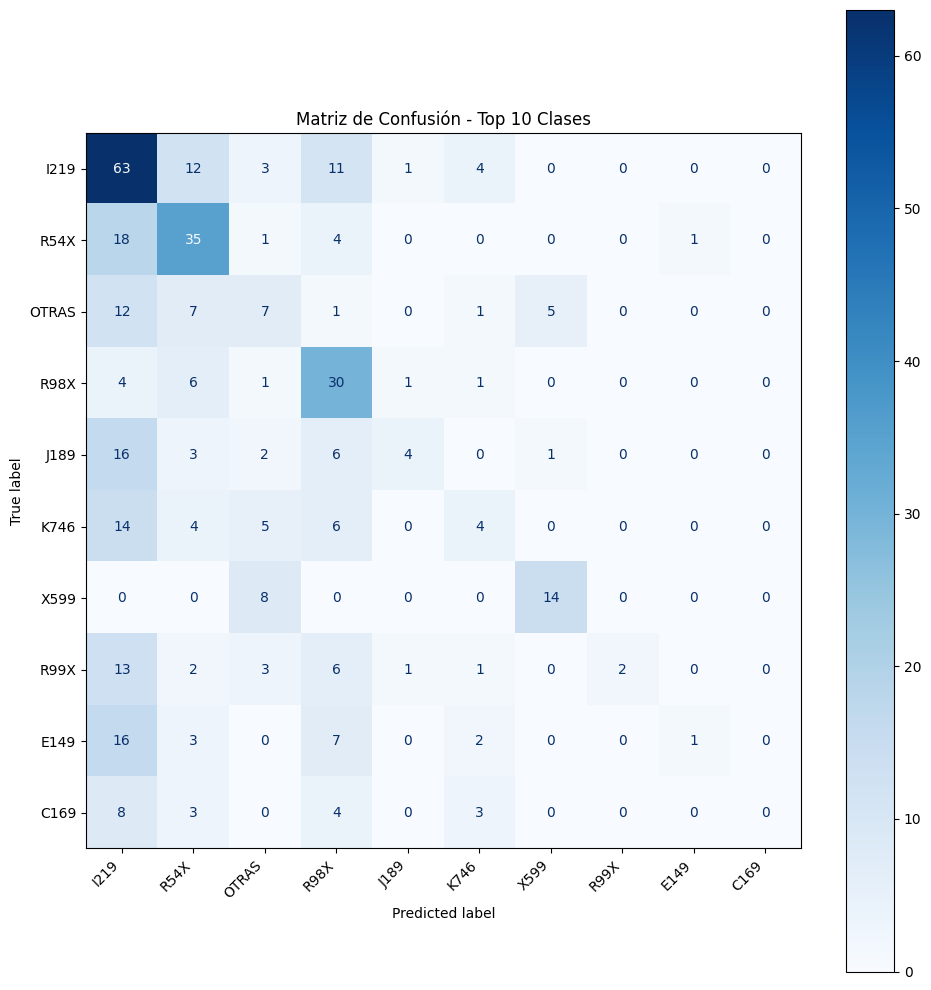

<ipython-input-18-286d2e17d4eb>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report.index, y=df_report['recall'], palette='Blues_d')


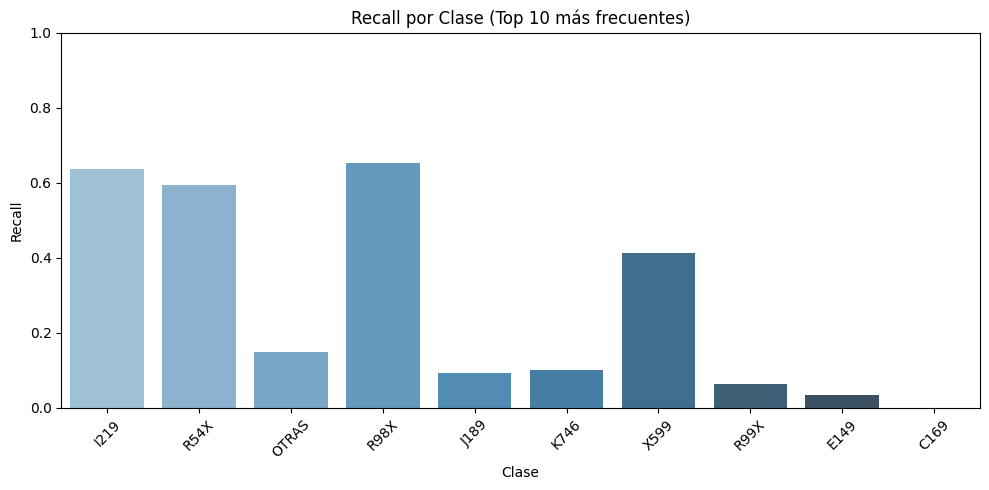

              precision    recall  f1-score   support

        I219       0.38      0.64      0.48        99
        R54X       0.47      0.59      0.52        59
       OTRAS       0.23      0.15      0.18        47
        R98X       0.40      0.65      0.50        46
        J189       0.57      0.09      0.16        43
        K746       0.25      0.10      0.14        40
        X599       0.70      0.41      0.52        34
        R99X       1.00      0.06      0.12        31
        E149       0.50      0.03      0.06        29
        C169       0.00      0.00      0.00        20

   micro avg       0.41      0.36      0.38       448
   macro avg       0.45      0.27      0.27       448
weighted avg       0.44      0.36      0.32       448



In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Contar frecuencia de cada clase
frecuencia = Counter(y_test_sample)
clases_mas_frecuentes = [clase for clase, _ in frecuencia.most_common(10)]  # top 10

# Filtrar datos
mask = np.isin(y_test_sample, clases_mas_frecuentes)
y_test_filtrado = y_test_sample[mask]
y_pred_filtrado = y_pred_final[mask]
X_test_filtrado = X_test_sample[mask]

# Obtener nombres de clases
nombres_clases_filtradas = le.inverse_transform(clases_mas_frecuentes)

# Mostrar matriz de confusión
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_filtrado,
    y_pred_filtrado,
    labels=clases_mas_frecuentes,
    display_labels=nombres_clases_filtradas,
    cmap='Blues',
    ax=ax
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)
ax.set_title("Matriz de Confusión - Top 10 Clases")
plt.tight_layout()
plt.show()


# 5. Gráfica de barras - Recall por clase
report = classification_report(
    y_test_filtrado,
    y_pred_filtrado,
    labels=clases_top10,
    target_names=nombres_clases_filtradas,
    output_dict=True,
    zero_division=0
)

# Convertir a DataFrame para gráficar
df_report = pd.DataFrame(report).transpose()
df_report = df_report.loc[nombres_clases_filtradas]  # solo clases, no 'accuracy'

# Graficar
plt.figure(figsize=(10, 5))
sns.barplot(x=df_report.index, y=df_report['recall'], palette='Blues_d')
plt.ylim(0, 1)
plt.title("Recall por Clase (Top 10 más frecuentes)")
plt.ylabel("Recall")
plt.xlabel("Clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Reporte solo para esas clases
print(classification_report(
    y_test_filtrado,
    y_pred_filtrado,
    labels=clases_mas_frecuentes,
    target_names=nombres_clases_filtradas,
    zero_division=0
))



# Discusión de Resultados del Modelo de Clasificación
1. Objetivo del modelo
El objetivo fue entrenar un modelo para predecir la clase de defunción según un conjunto de variables predictoras, el problema es de clasificación multiclase, por lo que se utilizaron métricas como precisión, recall, F1-score y la matriz de confusión.

2. Matriz de confusión
La matriz de confusión mostró una distribución desigual en el rendimiento del modelo. Las siguientes observaciones se destacan:

- Algunas clases como I219, R54X y R98X presentan una diagonal visible, lo que indica que el modelo logra identificarlas correctamente en varias ocasiones.

- Otras clases como C169, E149 y R99X tienen una diagonal poco pronunciada o casi inexistente, lo que sugiere que el modelo no logra distinguirlas de otras clases.

- También se observan errores comunes entre ciertas clases, lo que indica confusión sistemática del modelo en categorías con patrones similares o insuficiente diferenciación en los datos.

3. Análisis del classification_report
Las clases con mejor F1-score fueron:

- R54X (0.52), X599 (0.52) y R98X (0.50), lo que sugiere un desempeño equilibrado entre recall y precisión en esas categorías.

- Clases con desempeño deficiente como C169 (F1 = 0.00), E149 (F1 = 0.06) y R99X (F1 = 0.12) demuestran que el modelo no logró identificar adecuadamente estas etiquetas.

- La precisión macro (0.45) y recall macro (0.27) revelan un modelo con rendimiento muy variable entre clases, probablemente debido a un desbalance en la distribución de las clases.

- La media ponderada del F1-score (0.32) indica un rendimiento global bajo, influenciado tanto por las clases más comunes como por el pobre desempeño en las más difíciles.

